In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline 
plt.style.use('ggplot')

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from math import sqrt
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [45]:
## load data as time series 
df = pd.read_csv('a.us.txt', sep=",", 
                 header=0, 
                 index_col=0, 
                 parse_dates=True, 
                 squeeze=True)

In [46]:
df.head()

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
1999-11-18,30.713,33.754,27.002,29.702,66277506,0
1999-11-19,28.986,29.027,26.872,27.257,16142920,0
1999-11-22,27.886,29.702,27.044,29.702,6970266,0
1999-11-23,28.688,29.446,27.002,27.002,6332082,0
1999-11-24,27.083,28.309,27.002,27.717,5132147,0


In [47]:
df['Close'].describe()

count    4521.000000
mean       27.871357
std        12.944389
min         7.323800
25%        19.089000
50%        24.490000
75%        36.521000
max       107.320000
Name: Close, dtype: float64

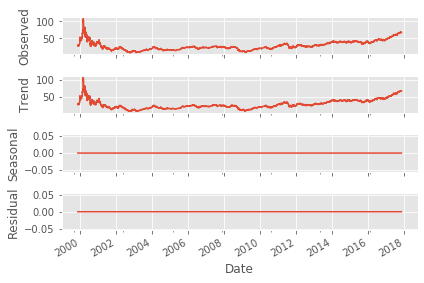

In [48]:
decompose = seasonal_decompose(df['Close'], model='additive', freq=1)

decompose.plot()
plt.show()

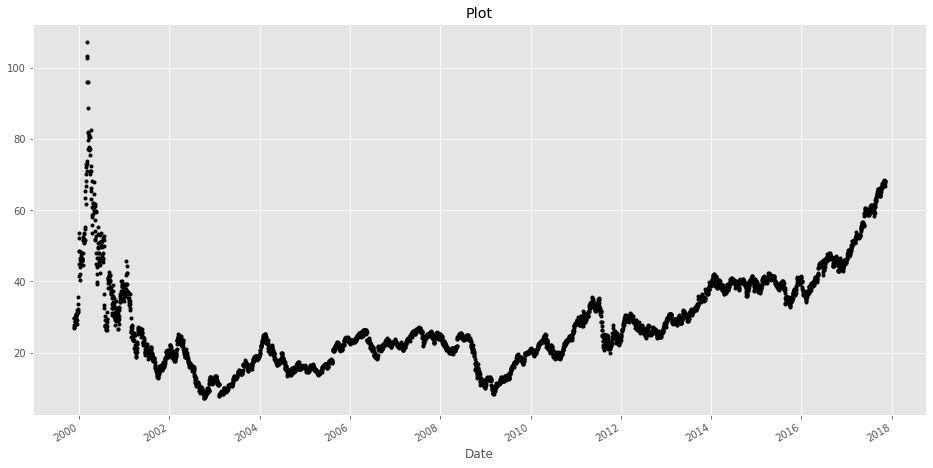

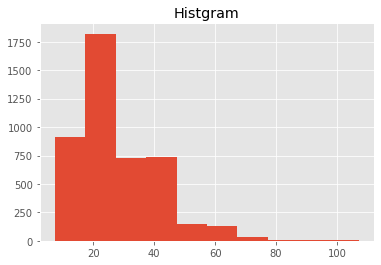

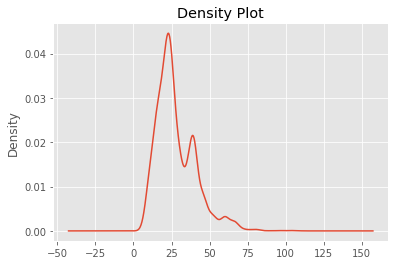

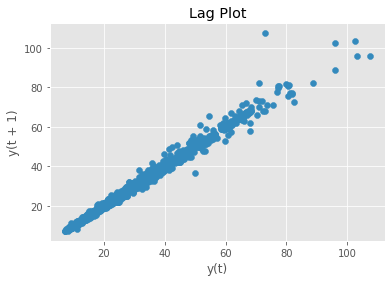

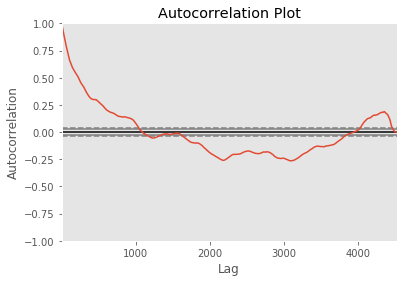

In [49]:
## visualize the dataset

df['Close'].plot(figsize=(16, 8), style='k.')
plt.title('Plot')
plt.show()

df['Close'].hist()
plt.title('Histgram')
plt.show()

df['Close'].plot(kind='kde')
plt.title('Density Plot')
plt.show()

pd.plotting.lag_plot(df['Close'])
plt.title('Lag Plot')
plt.show()

pd.plotting.autocorrelation_plot(df['Close'])
plt.title('Autocorrelation Plot')
plt.show()



### Downsampling

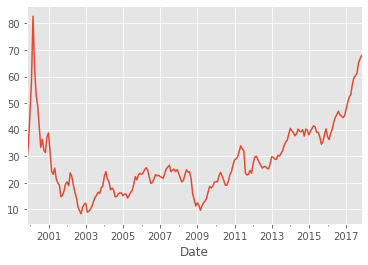

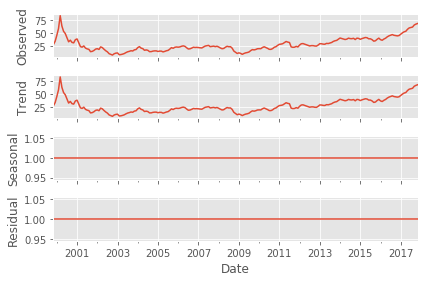

In [50]:
downsample = df['Close'].resample('M').mean()
downsample.plot()
plt.show()
results = seasonal_decompose(downsample, model='multiplicative', freq=1)
results.plot()
plt.show()

The data does not show seasonality, and decompose cannot catch the noise. 

## Build Persistence Model

In [51]:
X = df['Close'].values
X = X.astype('float32')

train_size = int(len(X) * 0.50)
train, test = X[0: train_size], X[train_size:]

history = [x for x in train]
predictions = list()

for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)
#     print(f'Prediciton = {round(yhat,3)}, Expected = {round(obs, 3)}')
rmse = np.sqrt(mean_squared_error(test, predictions))

print(f'RMSE: {round(rmse, 2)}')

RMSE: 0.5400000214576721


In [52]:
print(test[:10])
print(predictions[:10])

[11.906 10.937 11.672 12.561 12.522 12.616 12.71  11.652 11.906 12.286]
[12.826, 11.906, 10.937, 11.672, 12.561, 12.522, 12.616, 12.71, 11.652, 11.906]


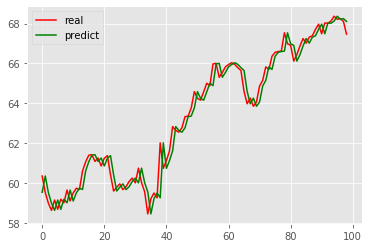

In [53]:
plt.figure()

plt.plot(test[-100:-1], color='red', label='real')
plt.plot(predictions[-100:-1], color='g', label='predict')
plt.legend()

plt.show()

## ARIMA Models

In [54]:
from statsmodels.tsa.stattools import adfuller

In [55]:
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i-1]
        diff.append(value)
    return pd.Series(diff)

series = df['Close']
X = series.values

stationary = difference(X)
stationary.index = series.index[1:]

result=adfuller(stationary)

print(f'ADF statistics: {round(result[0], 3)}')
print(f'p_value: {round(result[1], 5)}')
print('critical values')
for k, v in result[4].items():
    print(k, round(v,3))

ADF statistics: -13.538
p_value: 0.0
critical values
1% -3.432
5% -2.862
10% -2.567


In [56]:
stationary.to_csv('stationary_stock.csv', header=False)

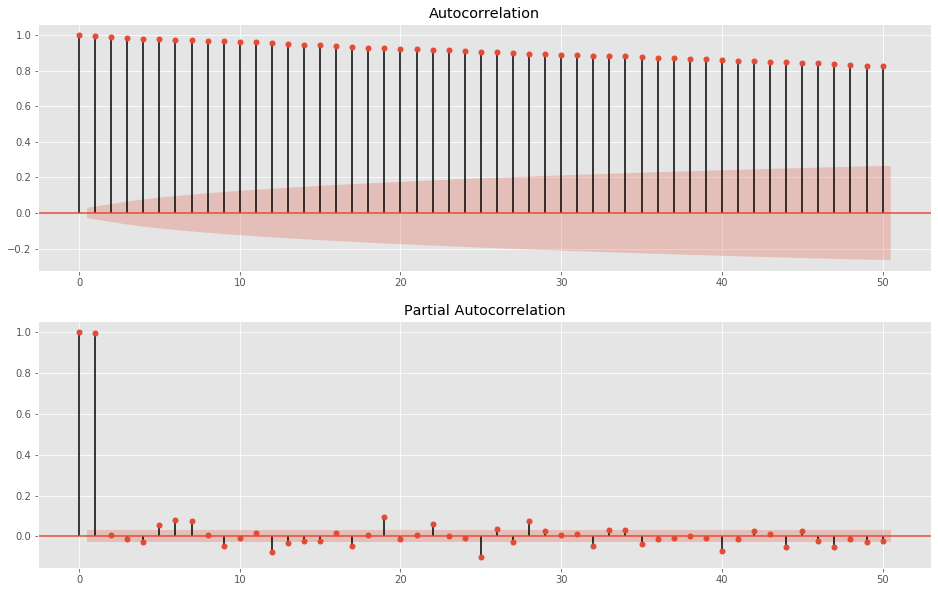

In [57]:
# ACF and PACF plots of time series:

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(16, 10))
plt.subplot(211)
plot_acf(df['Close'], lags=50, ax=plt.gca())

plt.subplot(212)
plot_pacf(df['Close'], lags=50, ax=plt.gca())

plt.show()

From the diffrencing, ACF, PACF, we can tell that the ARIMA with parameters of 1,1,1 might be the best.

In [5]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from math import log
from math import exp
from scipy.stats import boxcox

In [59]:
X = downsample.values
X = X.astype('float32')

train_size = int(len(X) * 0.50)
train, test = X[0: train_size], X[train_size:]

history = [x for x in train]
predictions = list()
for i in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)
rmse = sqrt(mean_squared_error(test, predictions))
print(rmse)

1.6987126327459308


# Power transform data

In [60]:
def boxcox_inverse(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)

In [61]:
X = downsample.values
X = X.astype('float32')

train_size = int(len(X) * 0.50)
train, test = X[0: train_size], X[train_size:]

history = [x for x in train]
predictions = list()

transformed, lam = boxcox(history)

In [62]:
X = downsample.values
X = X.astype('float32')

train_size = int(len(X) * 0.50)
train, test = X[0: train_size], X[train_size:]

history = [x for x in train]
predictions = list()

for i in range(len(test)):
    # transform
    transformed, lam = boxcox(history)
    if lam < -5:
        transformed, lam = history, 1
    
    model = ARIMA(transformed, order=(1,1,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    yhat = boxcox_inverse(yhat, lam)
    predictions.append(yhat)
    
    obs = test[i]
    history.append(obs)
    
#     print(f'Predicted={round(yhat, 3)}, Expected={round(obs, 3)}')
    
rsme = sqrt(mean_squared_error(test, predictions))
print(f'ERSM: {round(rsme, 3)}')   

ERSM: 1.673


In [63]:
import warnings

In [87]:
# grid search for p, d, q
def evaluate_arima_model(X, arima_order):
    X = X.astype('float32')
    train_size = int(len(X) * 0.5)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse


def evaluate_models(dataset, ps, ds, qs):
    dataset = dataset.astype('float32')
    for p in ps:
        for d in ds:
            for q in qs:
                order =(p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    print(f'ARIMA: {order}, RMSE = {rmse}')
                except:
                    continue

In [88]:
ps = range(1, 3)
ds = range(0, 2)
qs = range(1, 3)

warnings.filterwarnings('ignore')
evaluate_models(downsample.values, ps, ds, qs)

ARIMA: (1, 0, 1), RMSE = 1.9571223153927515
ARIMA: (1, 0, 2), RMSE = 1.9625656881227092
ARIMA: (1, 1, 1), RMSE = 1.6987126327459308
ARIMA: (2, 0, 1), RMSE = 2.006768901659277
ARIMA: (2, 1, 1), RMSE = 1.8637242432138943


As observed from PACF, the order = (1,1,1) yields the best performance.

In [123]:
X = downsample.values
X = X.astype('float32')

train_size = int(len(X) * 0.50)
train, test = X[0: train_size], X[train_size:]

from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
train_ = train.reshape(-1,1)
train_scaled = sc.fit_transform(train_)

In [164]:
len(test)

109

## Long Short Term Memory 

In [6]:
# load data as time series 
df1 = pd.read_csv('cag.us.txt', sep=",", 
                 header=0
                 )

In [173]:
# df1.describe()

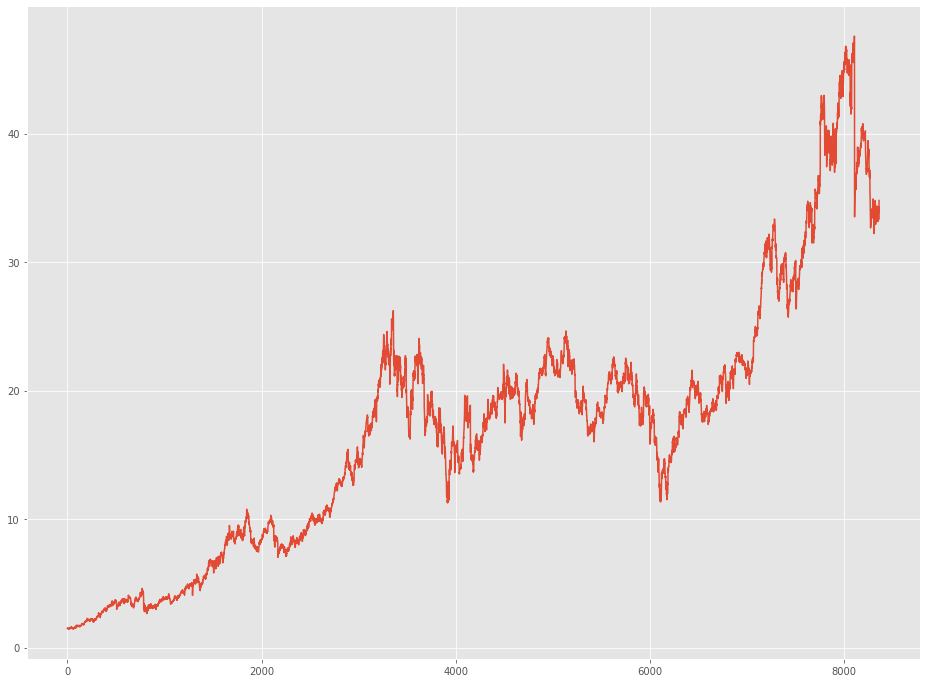

In [7]:
df1['Close'].plot(figsize=(16,12))

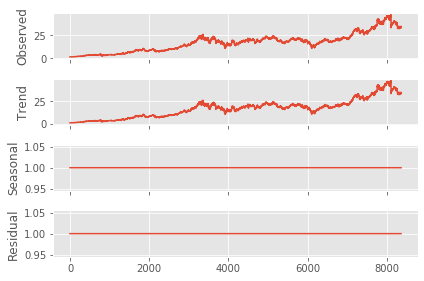

In [175]:
results = seasonal_decompose(df1['Close'], model='multiplicative', freq=1)
# plt.figure(figsize=(50,12))
results.plot()
plt.show()

## Normalize the data

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [19]:
X = df1['Close'].values
X = X.astype('float32')

train_size = int(len(X) * 0.90)
train, test = X[0: train_size], X[train_size:]

train_data = train.reshape(-1,1)
test_data = test.reshape(-1,1)

In [20]:
train_data

array([[ 1.5039],
       [ 1.4955],
       [ 1.5283],
       ...,
       [28.331 ],
       [27.992 ],
       [28.137 ]], dtype=float32)

By set up the smooting widow size as 2200, where will be 3 data points be affected, which is fine for the dataset size.

Feature normalization:

1. Scaling: Standard Scaler z = (x-u) / s 
            Min Max Scale:xit = (x_i - x_i_min) / (x_i_max - x_i_min)
            Normalizer: scales each data point such that the featuer vetor has a Euclidean length of 1, and often used when the direction of the data matters, not the feature vector.
            
2. Pipeline: from sklearn.pipeline import Pipeline

pip = Pipleline[('s', MinMaxScaler(copy=True), ('lr', LinearRegression())]

In this case, MinMaxScaler was used for normalization. Because the stock price strike a lot and some values might be close to zero when using MinMaxScaler, so that window normalization is used.

In [21]:
smoothing_window_size = 2200
for di in range(0,6600,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [22]:
train_data.size

7525

In [23]:
train_data = train_data.reshape(-1)

In [24]:
test_data=scaler.transform(test_data).reshape(-1)

In [25]:
test_data.size

837

## Smooth the data

Smoothing is usually done to help better see patterns in time series. Generally, smooth out of irregular roughness to see a clearer signal. 

The term filter is sometimes used to describe a smoothing procedure. For instance, if the smoothed value for a particular time is calculated as a linear combination of observations for surrounding times, it might be said that we have applied a linear filter to the data. 

More about smooth: https://online.stat.psu.edu/stat510/lesson/5/5.2

Exponential moving acerage is used to remove the inherent raggedness of the data in this case. 

x(t_1)_hat = gamma * x(t) + (1-gamma)* x(t)_hat

Only need to smooth trainning data. 

In [26]:
EMA = 0.0
gamma = 0.2

for t in range(6689):
    EMA = gamma * train_data[t] + (1-gamma) * EMA
    train_data[t] = EMA
    
all_data = np.concatenate([train_data, test_data], axis=0)
    

In [27]:
all_data

array([0.0012345 , 0.00204207, 0.0033911 , ..., 1.0592798 , 1.0373937 ,
       1.0899199 ], dtype=float32)

In [28]:
# Standard moving average model: which allows to predict one time step ahead by representing the future stock price
# as an average of the previously observed stock prices. Doing this for more than one step can produce quite
# bad results. 

window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size, N):
    
#     std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    
    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)  

In [29]:
print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00469


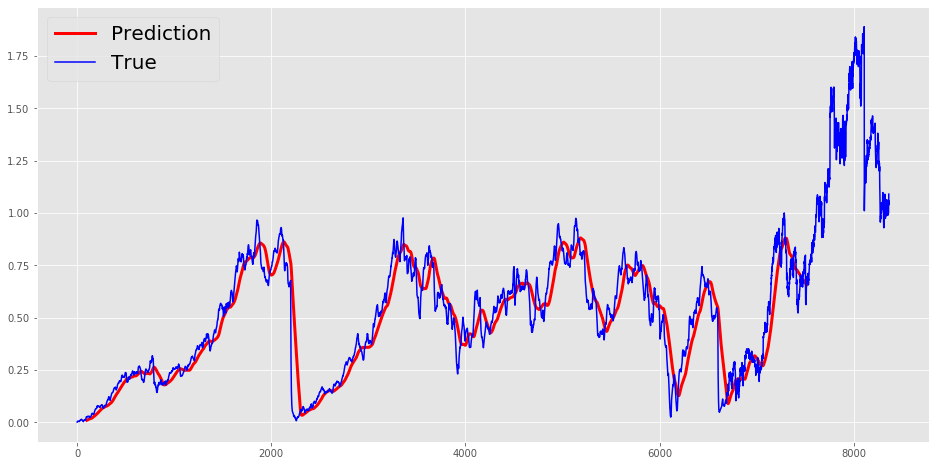

In [30]:
plt.figure(figsize=(16,8))

plt.plot(range(window_size,N),std_avg_predictions,color='r', linewidth=3, label='Prediction')
plt.plot(range(df1['Close'].shape[0]),all_data,color='b',label='True')
plt.legend(fontsize=(20))
plt.show()

#### LSTM model

Why LSTM model: 

LSTM model is able to predict more than one step into the future. LSTM is very powerful time series models that can predict arbitrary number of steps into the future. 

LSTM model has five essential components which allows it to model both long-term and short-term data.

1. Cell state (Ct) - This represents the internal memory of the cell which stores both short term memory and long-term memories.
2. Hidden state(ht) - This is output state information calculated with current input which we eventually use to predict the future stock market prices. The hidden state can decide to only retrive the short or long term or both types of memory stored in the cell state to make the next prediction.
3. Input gate(it) - Decides how much information from current flows to the cell state.
4. Forget gate(ft) - Decides how much information from the current input and the previous cell state flows into the current cell state.
5. Output gate(ot) - Decides how much information from the current cell state flows into the hidden state, so that if needed LSTM can only pick the long-term memories or short-term memories and long long-term memories.

x(t) = 0.4, EMA = 0.5, and gamma = 0.5

we want the output with the following equation:

X(t+1) = EMA(t) = gamma * EMA(t-1) + (1-gamma) * X(t)


In [31]:
data1 = df1['Close']

In [32]:
df1

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,1.5039,1.5202,1.4789,1.5039,269452,0
1,1984-09-10,1.5039,1.5202,1.4789,1.4955,231661,0
2,1984-09-11,1.5039,1.5283,1.5039,1.5283,785353,0
3,1984-09-12,1.5283,1.5283,1.5118,1.5283,1284825,0
4,1984-09-13,1.5283,1.5283,1.5039,1.5118,377887,0
...,...,...,...,...,...,...,...
8357,2017-11-06,33.8400,33.9300,33.2400,33.3200,2869514,0
8358,2017-11-07,33.3200,33.7600,33.2100,33.7600,2436664,0
8359,2017-11-08,33.8500,34.3800,33.8500,34.3100,2044805,0
8360,2017-11-09,33.9600,34.4800,33.9600,33.9600,2177336,0


In [33]:
train_set = df1.iloc[:7000, 4:5].values
test_set = df1.iloc[7000:, 4:5].values

In [34]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(50, 7000):
    X_train.append(training_set_scaled[i-50:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [35]:
X_train.shape

(6950, 50, 1)

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 5, batch_size = 16)

Train on 6950 samples
Epoch 1/5
6950/6950 [==============================] - 28s 4ms/sample - loss: 0.0081
Epoch 2/5
6950/6950 [==============================] - 25s 4ms/sample - loss: 0.0033
Epoch 3/5
6950/6950 [==============================] - 25s 4ms/sample - loss: 0.0026
Epoch 4/5
6950/6950 [==============================] - 25s 4ms/sample - loss: 0.0023
Epoch 5/5
6950/6950 [==============================] - 25s 4ms/sample - loss: 0.0021


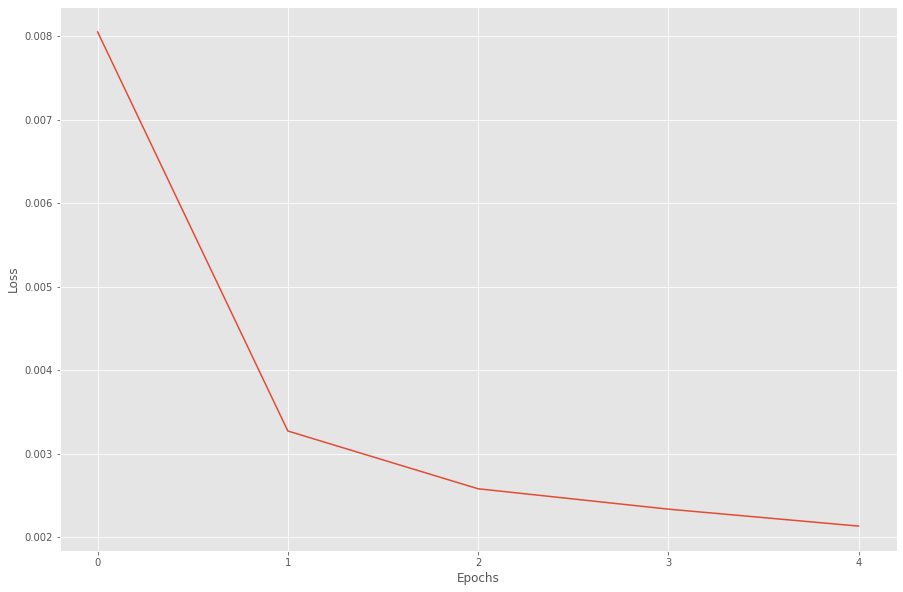

In [38]:
losses_lstm = model.history.history['loss']
plt.figure(figsize=(15,10))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)), losses_lstm)

In [39]:
dataset_train = df1.iloc[:8000, 4:5]
dataset_test = df1.iloc[8000:, 4:5]

dataset_total = pd.concat((dataset_train, dataset_test), axis=0)

inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 362):
    X_test.append(inputs[i-50:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(302, 50, 1)


In [40]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
# dataset_test['Predicted'] = predicted_stock_price

In [41]:
len(predicted_stock_price)

302

In [42]:
dataset_test_1 = df1.iloc[8060:, :]
dataset_test_1['predicted'] = predicted_stock_price

/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [46]:
dataset_test_1[['Date', 'Close', 'predicted']]

,Date,Close,predicted
8060,2016-09-01,44.754,34.931007
8061,2016-09-02,45.356,35.040287
8062,2016-09-06,45.133,35.139507
8063,2016-09-07,44.577,35.223633
8064,2016-09-08,43.644,35.281658
...,...,...,...
8357,2017-11-06,33.320,30.358242
8358,2017-11-07,33.760,30.347872
8359,2017-11-08,34.310,30.356121
8360,2017-11-09,33.960,30.384563


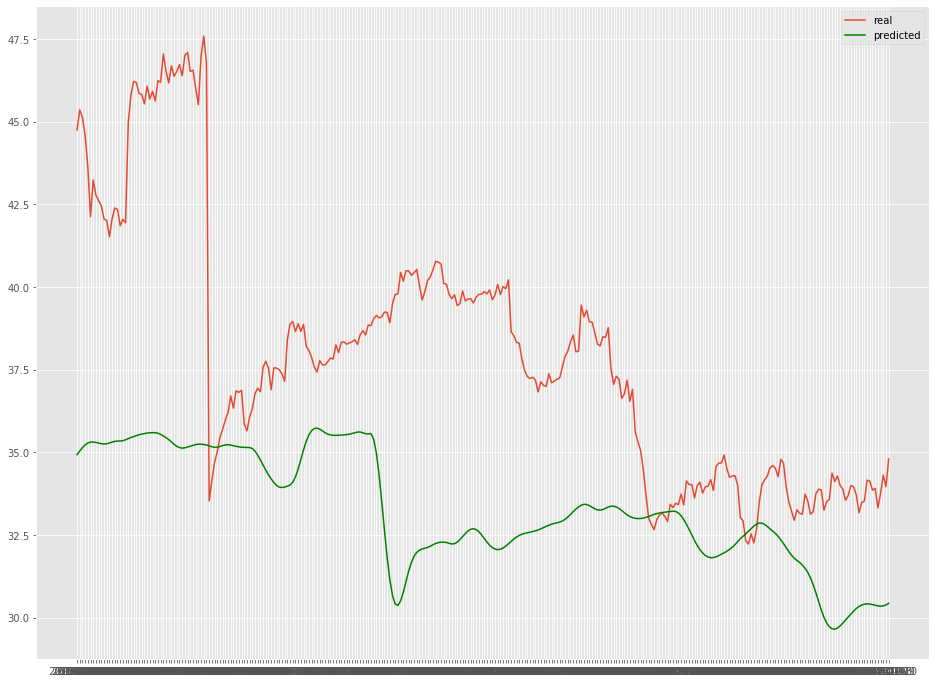

In [47]:
# Visualising the results
plt.figure(figsize=(16,12))
plt.plot(dataset_test_1['Date'], dataset_test_1['Close'], label='real')
plt.plot(dataset_test_1['Date'], dataset_test_1['predicted'], color ='green', label='predicted')
plt.legend()
plt.show()


In [50]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

n_input = 50
n_features= 1
generator = TimeseriesGenerator(training_set_scaled, training_set_scaled, length=n_input, batch_size=16)


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(n_input, n_features)))
# lstm_model.add(Dropout(0.5))
# # # Adding a second LSTM layer and some Dropout regularisation
# lstm_model.add(LSTM(200, return_sequences=True, activation='relu'))
# lstm_model.add(Dropout(0.5))
# # # Adding a third LSTM layer and some Dropout regularisation
# lstm_model.add(LSTM(50, return_sequences=True, activation='relu'))
# lstm_model.add(Dropout(0.5))
# # # Adding a fourth LSTM layer and some Dropout regularisation
# lstm_model.add(LSTM(200, return_sequences=True, activation='relu'))
# lstm_model.add(Dropout(0.5))
# Adding the output layer
lstm_model.add(Dense(units = 1))

# Compiling the RNN
lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 50, 200)           161600    
_________________________________________________________________
dense_2 (Dense)              (None, 50, 1)             201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [51]:
lstm_model.fit_generator(generator,epochs=5)

W1010 06:45:14.920577 4674072000 deprecation.py:323] From <ipython-input-51-dd06b33cc822>:1: Model.fit_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.fit, which supports generators.
W1010 06:45:14.924951 4674072000 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 435 steps
Epoch 1/5
435/435 [==============================] - 11s 24ms/step - loss: 0.0195
Epoch 2/5
435/435 [==============================] - 10s 22ms/step - loss: 0.0044
Epoch 3/5
435/435 [==============================] - 9s 22ms/step - loss: 0.0030
Epoch 4/5
435/435 [==============================] - 10s 22ms/step - loss: 0.0026
Epoch 5/5
435/435 [==============================] - 10s 22ms/step - loss: 0.0026


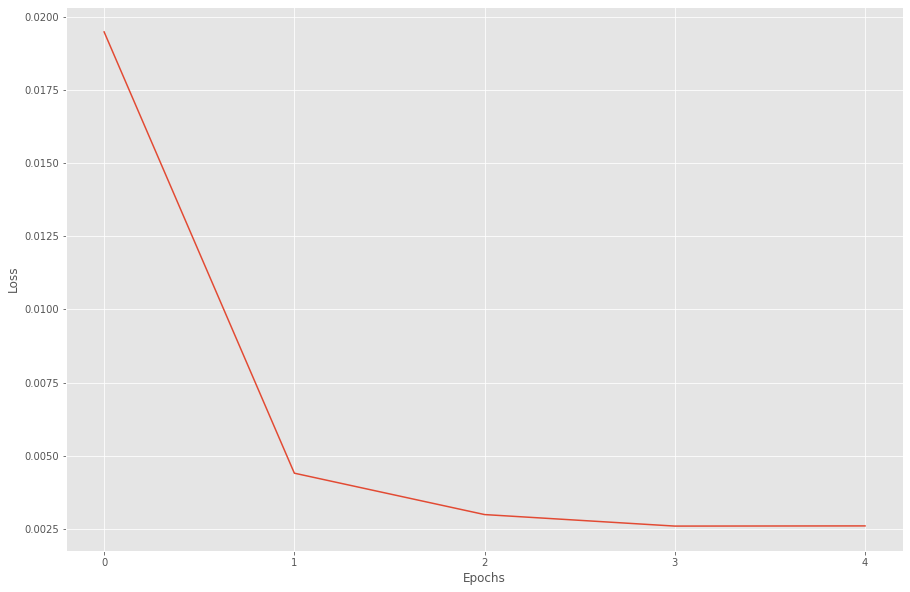

In [52]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(15,10))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)), losses_lstm)

In [64]:
# Not sure what is wrong here, will check
# look_back = 15  
# test_generator = TimeseriesGenerator(test_set, test_set, length=look_back, batch_size=1)
# prediction = lstm_model.predict_generator(test_generator)


In [60]:
prediction=prediction.reshape((-1))
test_set=test.reshape(-1)

(20205,)

In [65]:
# training_set_scaled[-n_input:]
# current_batch = batch.reshape((1, n_input, n_features))
# current_batch.shape
# lstm_pred = lstm_model.predict(current_batch)
# print(lstm_pred)
# print(current_batch)
# print(lstm_pred.shape)


In [14]:
import plotly.graph_objects as go

In [66]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=dataset_test_1['Close'], x=dataset_test_1['Date']), name='Real')
fig.add_trace(go.Scatter(y=dataset_test_1['predicted'], x=dataset_test_1['Date']), name='Predicted')
fig.update_layout(title = 'Test price')
fig.show()


TypeError: add_trace() got an unexpected keyword argument 'name'